# Model Inversion using Deep Leakage from Gradients

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from config import MODELS
from privacy_and_grokking.utils import get_device
from privacy_and_grokking.path_keeper import get_path_keeper

In [2]:
device = get_device()
pk = get_path_keeper()
mu = torch.tensor([0.1307], device=device)
std = torch.tensor([0.3081], device=device)

## Data

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = torchvision.datasets.MNIST(
    root=pk.CACHE, 
    train=True, 
    download=True, 
    transform=transform
)

data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)
x_truth, target_label = next(iter(data_loader))

## Helper

In [4]:
def cosine_similarity_loss(dummy_gradients, target_gradients):
    loss = torch.Tensor([0.0])
    for dum_g, tgt_g in zip(dummy_gradients, target_gradients):
        if dum_g.numel() == 0 or tgt_g.numel() == 0:
            continue
            
        d_flat = dum_g.view(-1)
        t_flat = tgt_g.view(-1)

        d_norm = d_flat / (d_flat.norm() + 1e-8)
        t_norm = t_flat / (t_flat.norm() + 1e-8)

        similarity = torch.dot(d_norm, t_norm)
        loss += (1 - similarity)
    
    return loss / len(dummy_gradients)

In [5]:
def total_variation_loss(img):
    """Total variation loss for smoothness regularization."""
    if img.dim() != 4:
        img = img.unsqueeze(0)
    
    b, c, h, w = img.size()
    tv_h = torch.pow(img[:, :, 1:, :] - img[:, :, :-1, :], 2).sum()
    tv_w = torch.pow(img[:, :, :, 1:] - img[:, :, :, :-1], 2).sum()
    return (tv_h + tv_w) / (b * c * h * w)

In [6]:
def l2_loss(dummy_gradients, target_gradients):
    """L2 loss between gradients as alternative to cosine similarity."""
    loss = 0.0
    for dum_g, tgt_g in zip(dummy_gradients, target_gradients):
        if dum_g.numel() == 0 or tgt_g.numel() == 0:
            continue
        loss += torch.norm(dum_g - tgt_g) ** 2
    return loss / len(dummy_gradients)

In [7]:
def reconstruct_image(model, x_truth, label, device, iterations=1000, lr=0.1, early_stop_thresh=1e-6):
    x_truth = x_truth.to(device)
    label = label.to(device)
    
    print(f"Starting reconstruction... (Target Label: {label.item()})")
    
    for param in model.parameters():
        param.requires_grad = True
    
    model.train()
    model.zero_grad()

    pred_truth = model(x_truth)
    criterion = nn.CrossEntropyLoss()
    loss_truth = criterion(pred_truth, label)
    
    target_gradients = torch.autograd.grad(
        loss_truth, 
        model.parameters(), 
        create_graph=False, # We don"t need gradients of gradients here
        retain_graph=False
    )
    target_gradients = [tg.detach().clone() for tg in target_gradients]
    
    model.eval()
    for param in model.parameters():
        param.requires_grad = False
    
    x_dummy = torch.randn_like(x_truth, device=device, requires_grad=True)
    if iterations <= 500:
        optimizer = optim.LBFGS([x_dummy], lr=lr, max_iter=20)
    else:
        optimizer = optim.Adam([x_dummy], lr=lr)
    
    history = {"total_loss": [], "grad_loss": [], "tv_loss": []}
    best_loss = float("inf")
    best_reconstruction = None
    
    def closure():
        optimizer.zero_grad()
        for param in model.parameters():
            param.requires_grad = True
        model.train()
        model.zero_grad()

        pred_dummy = model(x_dummy)
        loss_dummy = criterion(pred_dummy, label)

        dummy_gradients = torch.autograd.grad(
            loss_dummy, 
            model.parameters(), 
            create_graph=True,
            retain_graph=True
        )

        model.eval()
        for param in model.parameters():
            param.requires_grad = False
        
        grad_loss = cosine_similarity_loss(dummy_gradients, target_gradients)
        tv_loss = total_variation_loss(x_dummy)
        image_prior = 0.01 * torch.norm(x_dummy) # Image prior
        
        total_loss = grad_loss + (1e-4 * tv_loss) + image_prior
        total_loss.backward(retain_graph=True)

        return total_loss, grad_loss, tv_loss
    
    for i in range(iterations):
        if isinstance(optimizer, optim.LBFGS):
            total_loss, grad_loss, tv_loss = closure()
            optimizer.step(lambda: closure()[0])
        else:
            total_loss, grad_loss, tv_loss = closure()
            optimizer.step()
        
        history["total_loss"].append(total_loss.item())
        history["grad_loss"].append(grad_loss.item())
        history["tv_loss"].append(tv_loss.item())
        
        if total_loss.item() < best_loss:
            best_loss = total_loss.item()
            best_reconstruction = x_dummy.detach().clone()
        
        with torch.no_grad():
            x_dummy.clamp_(-3, 3)

        if i % 50 == 0:
            print(f"Iter {i}: Loss {total_loss.item():.6f} "
                  f"(Grad: {grad_loss.item():.6f}, TV: {tv_loss.item():.6f})")

        if grad_loss.item() < early_stop_thresh:
            print(f"Early stopping at iteration {i}")
            break
    
    return best_reconstruction if best_reconstruction is not None else x_dummy.detach(), history

In [8]:
def visualize_reconstruction(model, x_truth, x_reconstructed, history):
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))

    axs[0, 0].imshow(x_truth.squeeze().cpu(), cmap="gray")
    axs[0, 0].set_title("Ground Truth")
    axs[0, 0].axis("off")
    
    axs[0, 1].imshow(x_reconstructed.squeeze().cpu(), cmap="gray")
    axs[0, 1].set_title("Reconstructed")
    axs[0, 1].axis("off")
    
    diff = torch.abs(x_truth.squeeze().cpu() - x_reconstructed.squeeze().cpu())
    axs[0, 2].imshow(diff, cmap="hot")
    axs[0, 2].set_title(f"Absolute Difference\nMSE: {torch.mean(diff**2):.4f}")
    axs[0, 2].axis("off")
    
    axs[1, 0].plot(history["total_loss"])
    axs[1, 0].set_title("Total Loss")
    axs[1, 0].set_xlabel("Iteration")
    axs[1, 0].set_yscale("log")
    axs[1, 0].grid(True)
    
    axs[1, 1].plot(history["grad_loss"])
    axs[1, 1].set_title("Gradient Loss")
    axs[1, 1].set_xlabel("Iteration")
    axs[1, 1].set_yscale("log")
    axs[1, 1].grid(True)
    
    axs[1, 2].plot(history["tv_loss"])
    axs[1, 2].set_title("TV Loss")
    axs[1, 2].set_xlabel("Iteration")
    axs[1, 2].set_yscale("log")
    axs[1, 2].grid(True)

    fig.suptitle("Reconstruction ({} | {})".format(model.id, model.name))
    
    plt.tight_layout()
    plt.show()

## Attack

Starting reconstruction... (Target Label: 3)
Iter 0: Loss 1.114319 (Grad: 0.833335, TV: 3.936890)
Iter 50: Loss 0.036286 (Grad: 0.022735, TV: 0.002096)
Iter 100: Loss 0.036286 (Grad: 0.022735, TV: 0.002096)
Iter 150: Loss 0.036286 (Grad: 0.022735, TV: 0.002096)
Iter 200: Loss 0.036286 (Grad: 0.022735, TV: 0.002096)
Iter 250: Loss 0.036286 (Grad: 0.022735, TV: 0.002096)
Iter 300: Loss 0.036286 (Grad: 0.022735, TV: 0.002096)
Iter 350: Loss 0.036286 (Grad: 0.022735, TV: 0.002096)
Iter 400: Loss 0.036286 (Grad: 0.022735, TV: 0.002096)
Iter 450: Loss 0.036286 (Grad: 0.022735, TV: 0.002096)


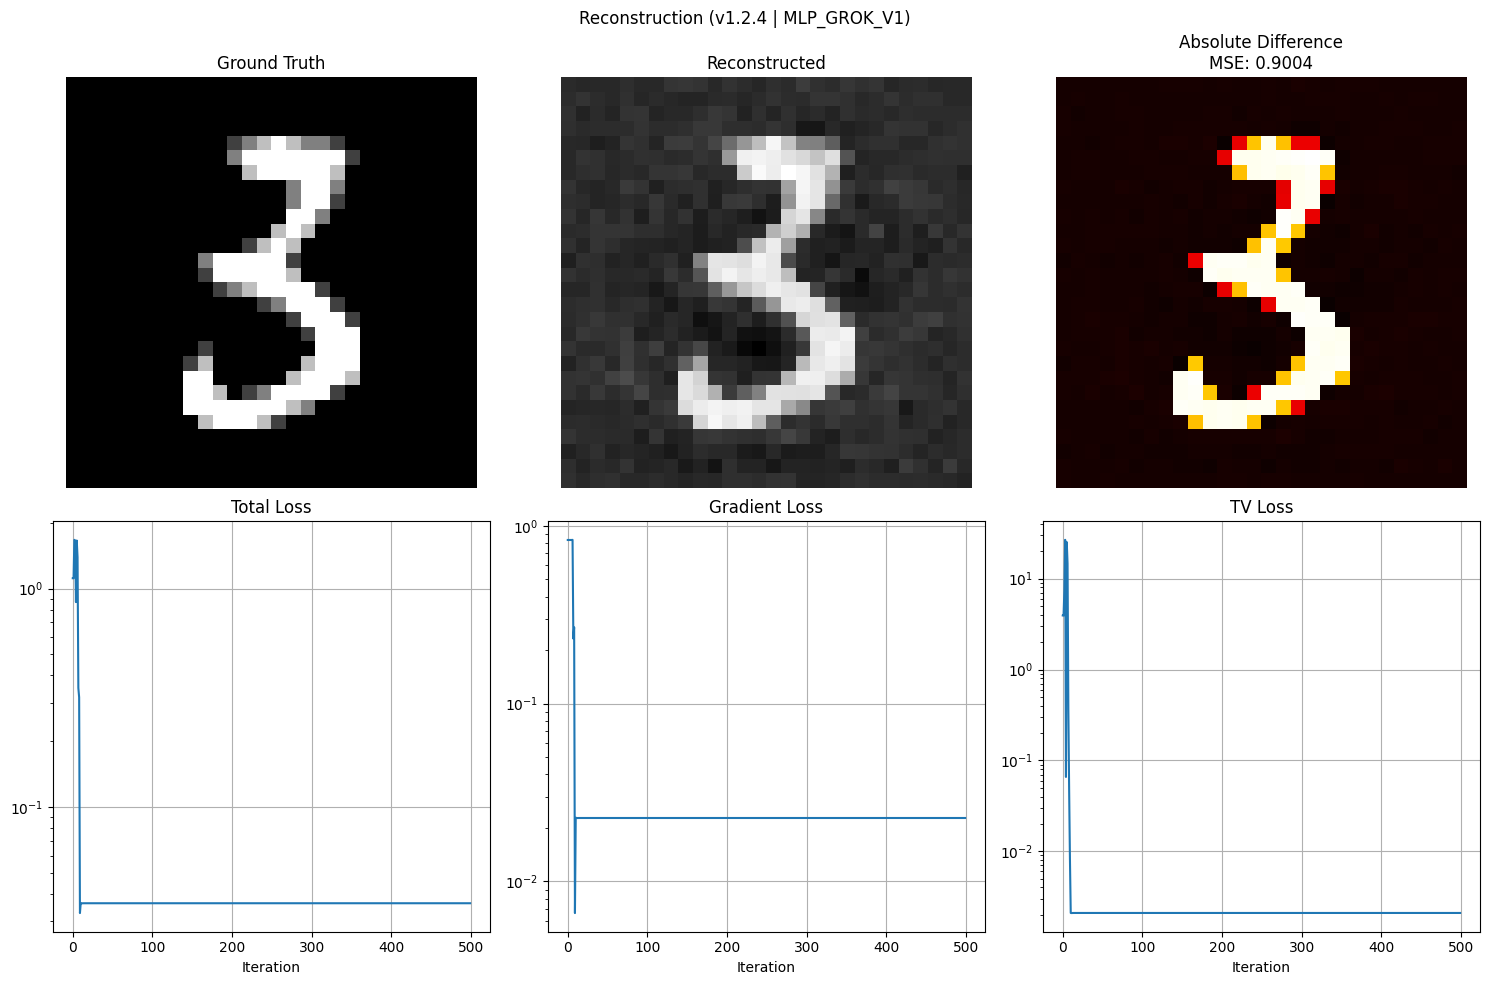

Reconstruction MSE: 0.900350
Reconstruction PSNR: 0.46 dB
Starting reconstruction... (Target Label: 3)
Iter 0: Loss 1.109356 (Grad: 0.833338, TV: 3.765528)
Iter 50: Loss 0.017534 (Grad: 0.007549, TV: 0.001149)
Iter 100: Loss 0.017534 (Grad: 0.007549, TV: 0.001149)
Iter 150: Loss 0.017534 (Grad: 0.007549, TV: 0.001149)
Iter 200: Loss 0.017534 (Grad: 0.007549, TV: 0.001149)
Iter 250: Loss 0.017534 (Grad: 0.007549, TV: 0.001149)
Iter 300: Loss 0.017534 (Grad: 0.007549, TV: 0.001149)
Iter 350: Loss 0.017534 (Grad: 0.007549, TV: 0.001149)
Iter 400: Loss 0.017534 (Grad: 0.007549, TV: 0.001149)
Iter 450: Loss 0.017534 (Grad: 0.007549, TV: 0.001149)


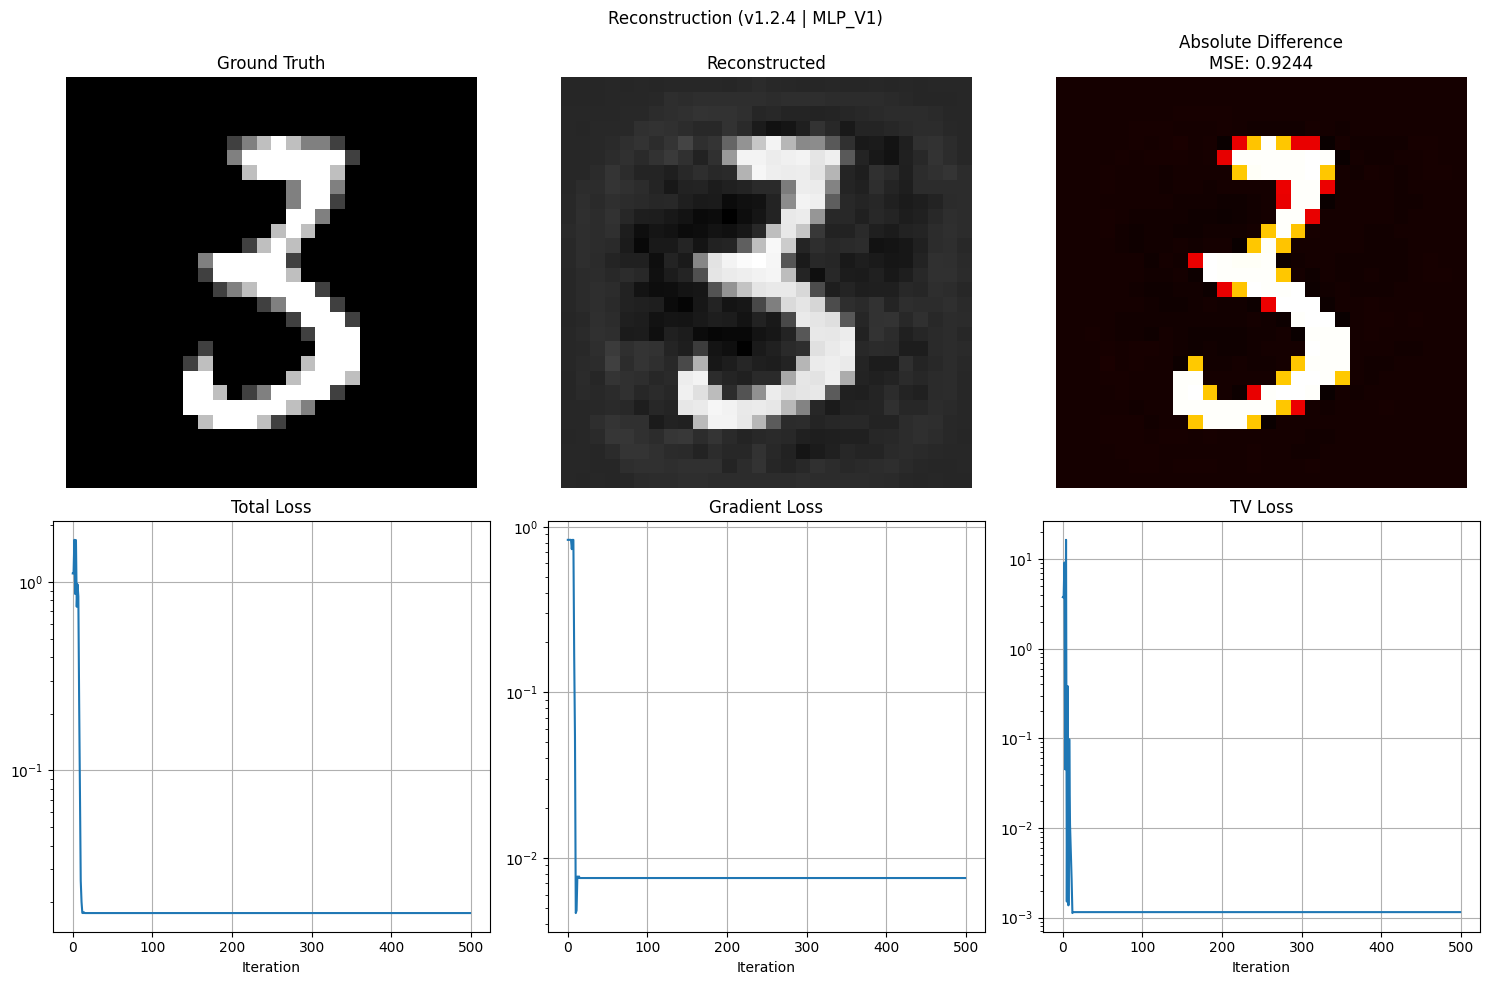

Reconstruction MSE: 0.924362
Reconstruction PSNR: 0.34 dB
Starting reconstruction... (Target Label: 3)
Iter 0: Loss 1.237120 (Grad: 0.960651, TV: 3.840869)
Iter 50: Loss 1.022360 (Grad: 0.647750, TV: 7.318400)
Iter 100: Loss 0.803375 (Grad: 0.696625, TV: 0.523531)
Iter 150: Loss 0.424871 (Grad: 0.364741, TV: 0.143922)
Iter 200: Loss 0.295650 (Grad: 0.233537, TV: 0.156809)
Iter 250: Loss 0.289729 (Grad: 0.231897, TV: 0.134953)
Iter 300: Loss 0.320272 (Grad: 0.261758, TV: 0.138840)
Iter 350: Loss 0.372673 (Grad: 0.313200, TV: 0.145379)
Iter 400: Loss 0.369101 (Grad: 0.310011, TV: 0.147621)
Iter 450: Loss 0.302763 (Grad: 0.245631, TV: 0.142394)


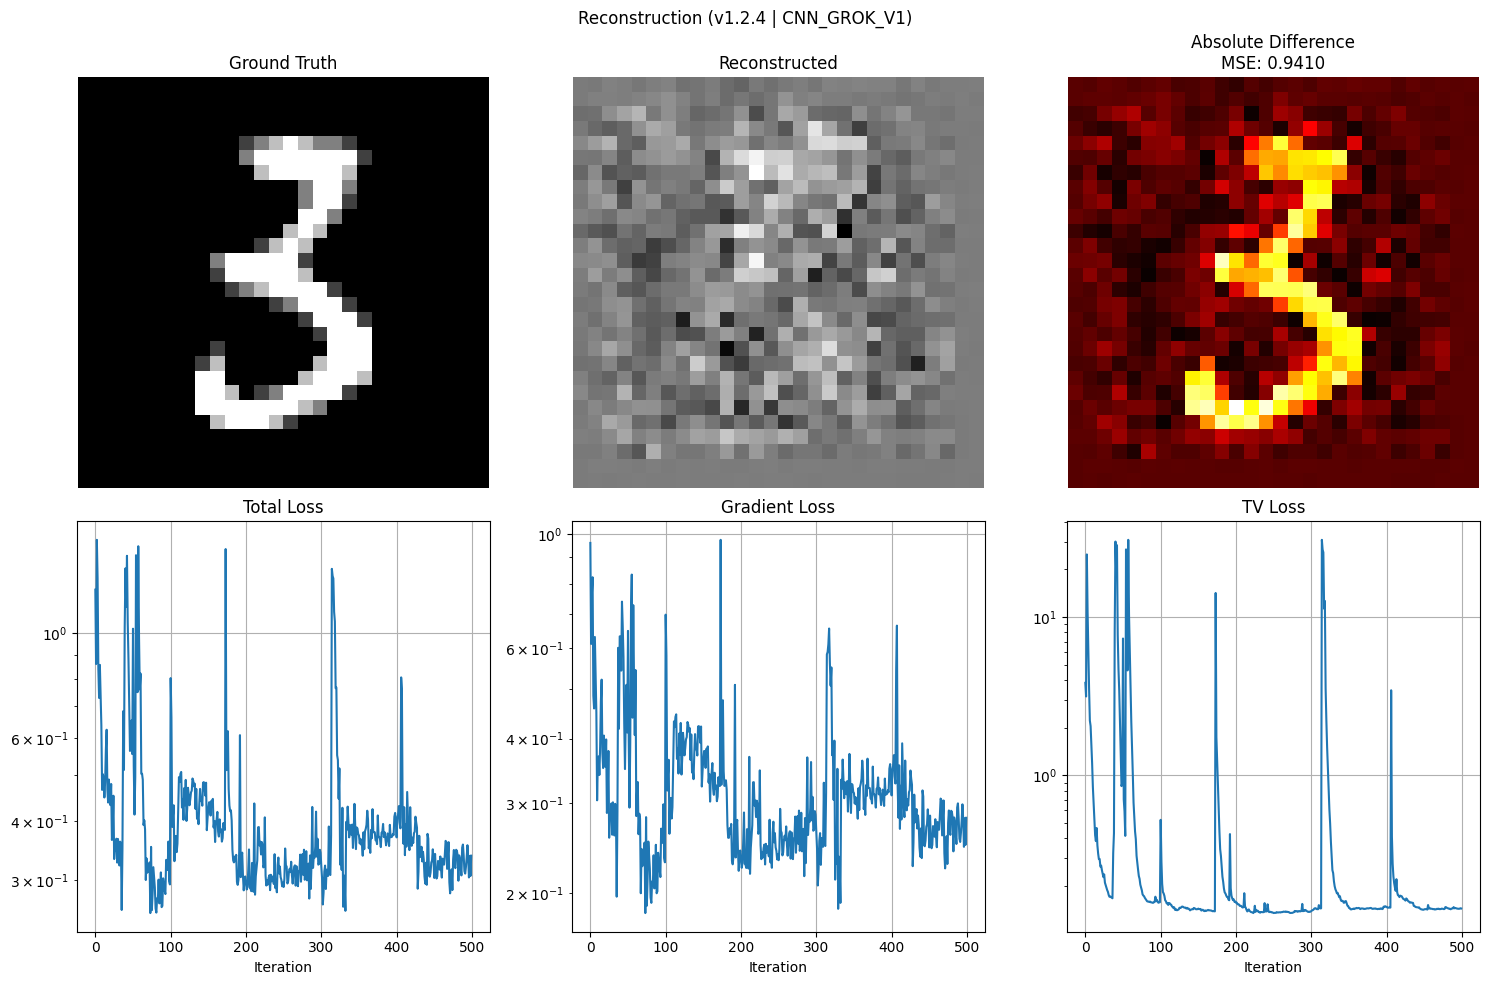

Reconstruction MSE: 0.941020
Reconstruction PSNR: 0.26 dB
Starting reconstruction... (Target Label: 3)
Iter 0: Loss 1.117895 (Grad: 0.837091, TV: 3.881244)
Iter 50: Loss 0.548371 (Grad: 0.357450, TV: 1.371933)
Iter 100: Loss 0.391889 (Grad: 0.286631, TV: 0.363059)
Iter 150: Loss 1.600461 (Grad: 0.842184, TV: 24.288141)
Iter 200: Loss 0.287063 (Grad: 0.217108, TV: 0.152855)
Iter 250: Loss 0.268134 (Grad: 0.218721, TV: 0.060718)
Iter 300: Loss 0.986109 (Grad: 0.826083, TV: 1.125721)
Iter 350: Loss 0.327688 (Grad: 0.281526, TV: 0.074149)
Iter 400: Loss 0.269341 (Grad: 0.214655, TV: 0.090097)
Iter 450: Loss 0.251019 (Grad: 0.202528, TV: 0.064816)


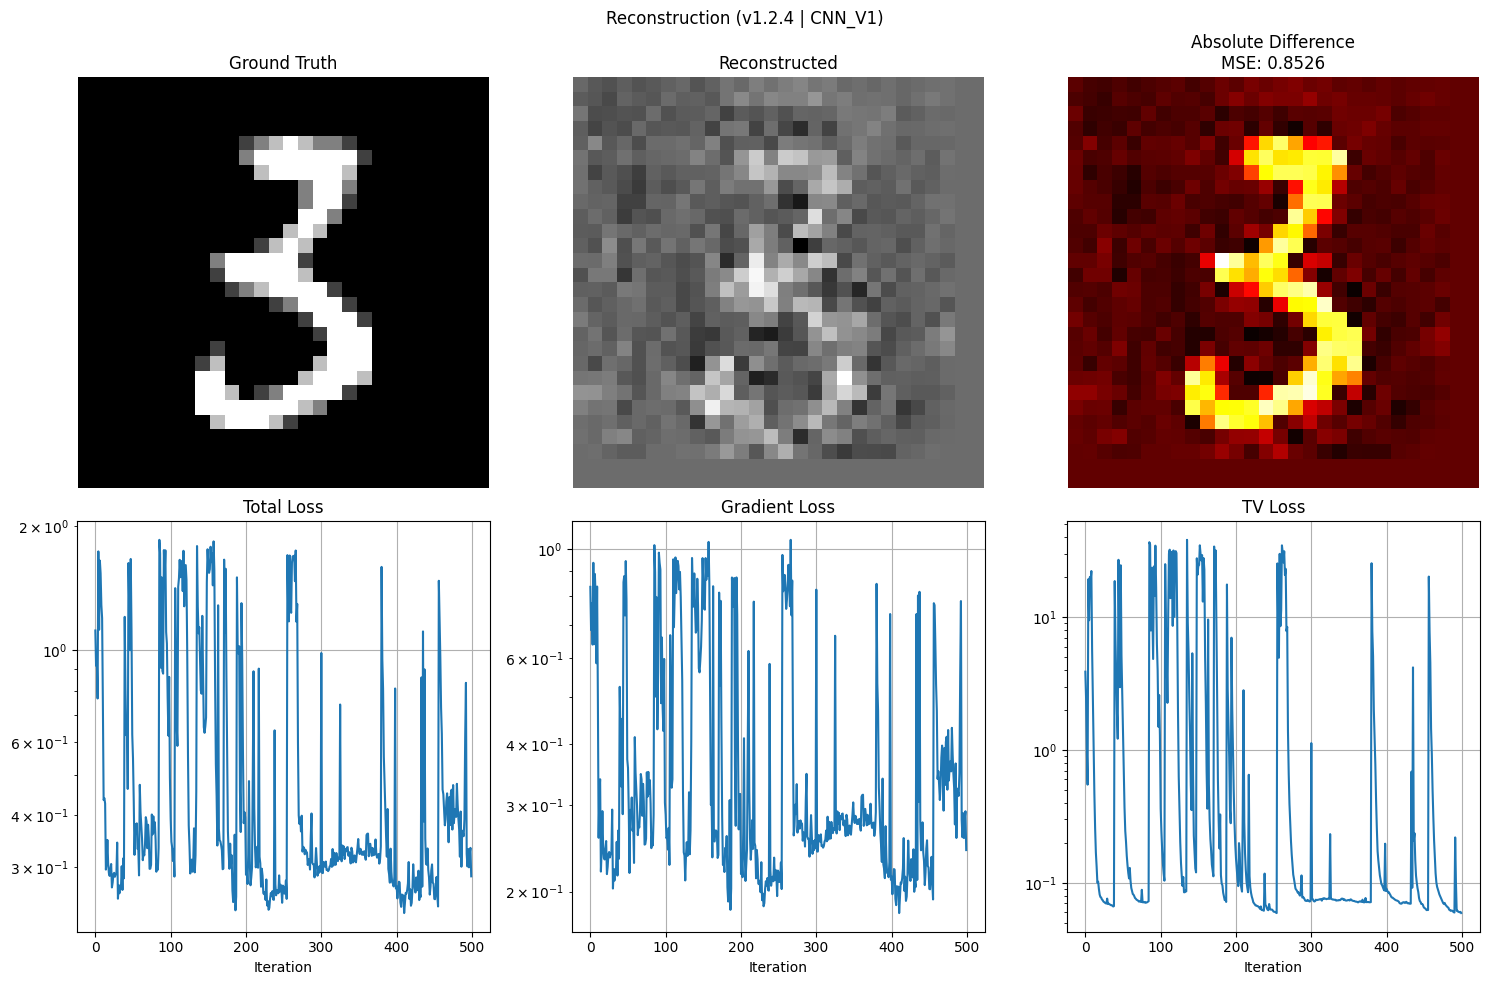

Reconstruction MSE: 0.852616
Reconstruction PSNR: 0.69 dB


In [9]:
for model in MODELS:
    pk.set_params({"run_id": model.id, "model": model.name, "step": model.updates[-1]})

    target_model = model.model_class()
    target_model.load_state_dict(torch.load(pk.MODEL_TORCH, weights_only=True, map_location=device))
    target_model.to(device)
    target_model.eval()
    for param in target_model.parameters():
        param.requires_grad = False
    
    x_reconstructed, loss_history = reconstruct_image(
        target_model, 
        x_truth, 
        target_label, 
        device=device,
        iterations=500,
        lr=0.1,
    )
    visualize_reconstruction(model, x_truth, x_reconstructed, loss_history)
    mse = torch.mean((x_truth - x_reconstructed)**2).item()
    psnr = 20 * torch.log10(torch.tensor(1.0) / torch.sqrt(torch.tensor(mse))).item()
    print(f"Reconstruction MSE: {mse:.6f}")
    print(f"Reconstruction PSNR: {psnr:.2f} dB")